# Support Vector Machines

This notebooks contains my exploration of SVM models.  The product of this notebook will be a model that can be used for prediction.

------

## Contents<a id='Contents'></a>
* [XXXX](#introduction--feature-descriptions)
* [Imports & Reading Data](#imports--readingpreparing-data)
---

## Imports & Reading Data

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns',None)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import recall_score
from sklearn.svm import LinearSVC, SVC

from csv import DictWriter

In [2]:
# Read csv into a pandas dataframe
df = pd.read_csv('../data/cleaned_heart_data.csv')
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ExerciseAngina_Y,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,Oldpeak_is_zero
0,40,140,289.0,0,172,0.0,0,1,0,1,0,0,1,0,0,1,1
1,49,160,180.0,0,156,1.0,1,0,0,0,1,0,1,0,1,0,0
2,37,130,283.0,0,98,0.0,0,1,0,1,0,0,0,1,0,1,1
3,48,138,214.0,0,108,1.5,1,0,1,0,0,0,1,0,1,0,0
4,54,150,195.0,0,122,0.0,0,1,0,0,1,0,1,0,0,1,1


In [3]:
# Split data into predictor features (X) and target feature (y)
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

In [4]:
# Split the data into a training and a test set (random state set for reproducability)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [5]:
#Impute missing cholesterol with medians for baseline models
imputer_for_baseline = SimpleImputer(strategy='median')
X_train_imputed =imputer_for_baseline.fit_transform(X_train)
X_test_imputed = imputer_for_baseline.fit_transform(X_test)

## Linear SVC

In [6]:
linear_svc_pipe = make_pipeline(SimpleImputer(),
                                StandardScaler(),
                                LinearSVC(max_iter=2000, dual=False))
params = {'simpleimputer__strategy': ['mean', 'median'],
          'standardscaler': [None, StandardScaler()],
          'linearsvc__penalty': ['l1', 'l2'],
          'linearsvc__loss': ['squared_hinge'],
          'linearsvc__intercept_scaling': [1, 5, 10],
          'linearsvc__class_weight': [None, 'balanced']
          }
grid_cv_linear = GridSearchCV(estimator=linear_svc_pipe, param_grid=params, cv=5, scoring='recall', n_jobs=-1)
grid_cv_linear.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(dual=False, max_iter=2000))]),
             n_jobs=-1,
             param_grid={'linearsvc__class_weight': [None, 'balanced'],
                         'linearsvc__intercept_scaling': [1, 5, 10],
                         'linearsvc__loss': ['squared_hinge'],
                         'linearsvc__penalty': ['l1', 'l2'],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [None, StandardScaler()]},
             scoring='recall')

In [7]:
grid_cv_results_linear=pd.DataFrame(grid_cv_linear.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_linear[['param_simpleimputer__strategy', 'param_standardscaler', 
                        'param_linearsvc__penalty', 'param_linearsvc__loss', 'param_linearsvc__intercept_scaling', 'param_linearsvc__class_weight', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

,param_simpleimputer__strategy,param_standardscaler,param_linearsvc__penalty,param_linearsvc__loss,param_linearsvc__intercept_scaling,param_linearsvc__class_weight,mean_test_score,std_test_score,rank_test_score
0,mean,None,l1,squared_hinge,1,None,0.886365,0.062928,1
4,mean,None,l2,squared_hinge,1,None,0.886365,0.062928,1
6,median,None,l2,squared_hinge,1,None,0.886365,0.062928,1
16,mean,None,l1,squared_hinge,10,None,0.886336,0.058639,4
2,median,None,l1,squared_hinge,1,None,0.883955,0.060081,5
18,median,None,l1,squared_hinge,10,None,0.883926,0.061048,6
1,mean,StandardScaler(),l1,squared_hinge,1,None,0.883926,0.061048,6
8,mean,None,l1,squared_hinge,5,None,0.883926,0.061048,6
9,mean,StandardScaler(),l1,squared_hinge,5,None,0.883926,0.061048,6
10,median,None,l1,squared_hinge,5,None,0.883926,0.061048,6


In [8]:
final_linear_svc = grid_cv_linear.best_estimator_
final_linear_svc.fit(X_train, y_train)

y_test_pred = final_linear_svc.predict(X_test)
linear_svc_test_recall = recall_score(y_test, y_test_pred)
linear_svc_cv_score = cross_val_score(final_linear_svc, X_train, y_train, 
                                      cv = 5, scoring = "recall").mean()

print(f'Linear SVC Train CV Score (recall): {linear_svc_cv_score:.3f}')
print(f'Linear SVC Test Recall: {linear_svc_test_recall:.3f}')

Linear SVC Train CV Score (recall): 0.886
Linear SVC Test Recall: 0.904


In [9]:
final_linear_svc_performance = {'model': 'linear_svc', 
                          'params': final_linear_svc.get_params(), 
                          'train_score_cv_recall': linear_svc_cv_score, 
                          'test_score_recall': linear_svc_test_recall}

field_names = final_linear_svc_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_linear_svc_performance)

## Support Vector Machine

In [10]:
svm_baseline = SVC()
cv_score_svm_baseline = cross_val_score(svm_baseline, X_train_imputed, y_train, cv=5, 
                                        scoring='recall').mean()
svm_baseline.fit(X_train_imputed, y_train)
baseline_svm_y_hat = svm_baseline.predict(X_test_imputed)
recall_svm_baseline = recall_score(y_test, baseline_svm_y_hat)

print(f'Baseline SVM Train CV Score (recall): {cv_score_svm_baseline:.3f}')
print(f'Baseline SVM Test Recall: {recall_svm_baseline:.3f}')

Baseline SVM Train CV Score (recall): 0.806
Baseline SVM Test Recall: 0.862


In [12]:
svm_pipe = make_pipeline(SimpleImputer(),
                         StandardScaler(),
                         SVC())
params = [{'simpleimputer__strategy': ['mean', 'median'],
          'standardscaler': [None, StandardScaler()],
          'svc__C': [0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
          'svc__kernel': ['rbf', 'sigmoid'],
          'svc__gamma': ['scale', 'auto'],
          'svc__class_weight': [None, 'balanced'],
          },
        {'simpleimputer__strategy': ['mean', 'median'],
          'standardscaler': [None, StandardScaler()],
          'svc__C': [0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
          'svc__kernel': ['poly'],
          'svc__gamma': ['scale'],
          'svc__class_weight': [None, 'balanced'],
          }]

grid_cv_svm = GridSearchCV(estimator=svm_pipe, param_grid=params, 
                            cv=5, scoring='recall', n_jobs=-1)
grid_cv_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'simpleimputer__strategy': ['mean', 'median'],
                          'standardscaler': [None, StandardScaler()],
                          'svc__C': [0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
                          'svc__class_weight': [None, 'balanced'],
                          'svc__gamma': ['scale', 'auto'],
                          'svc__kernel': ['rbf', 'sigmoid']},
                         {'simpleimputer__strategy': ['mean', 'median'],
                          'standardscaler': [None, StandardScaler()],
                          'svc__C': [0.2, 0.5, 1.0, 2.0, 5.0, 10.0],
                          'svc__class_weight': [None, 'balanced'],
                          'svc__gamma': ['scale'], 'svc__kernel': ['poly']}],
             scoring='recall')

In [17]:
grid_cv_results_svm=pd.DataFrame(grid_cv_svm.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_svm[['param_simpleimputer__strategy', 'param_standardscaler',
                      'param_svc__C', 'param_svc__kernel', 'param_svc__gamma', 'param_svc__class_weight',
                      'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

,param_simpleimputer__strategy,param_standardscaler,param_svc__C,param_svc__kernel,param_svc__gamma,param_svc__class_weight,mean_test_score,std_test_score,rank_test_score
43,mean,None,10.0,sigmoid,auto,None,1.0,0.0,1
11,mean,None,0.5,sigmoid,auto,None,1.0,0.0,1
35,mean,None,5.0,sigmoid,auto,None,1.0,0.0,1
1,mean,None,0.2,sigmoid,scale,None,1.0,0.0,1
27,mean,None,2.0,sigmoid,auto,None,1.0,0.0,1
139,median,None,10.0,sigmoid,auto,None,1.0,0.0,1
19,mean,None,1.0,sigmoid,auto,None,1.0,0.0,1
131,median,None,5.0,sigmoid,auto,None,1.0,0.0,1
107,median,None,0.5,sigmoid,auto,None,1.0,0.0,1
106,median,None,0.5,rbf,auto,None,1.0,0.0,1


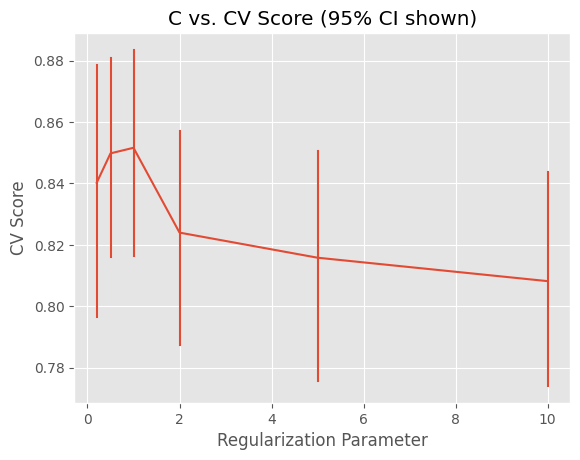

In [19]:
sns.lineplot(data=grid_cv_results_svm, x='param_svc__C', y='mean_test_score', 
             err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Regularization Parameter')
plt.title('C vs. CV Score (95% CI shown)')
plt.show()

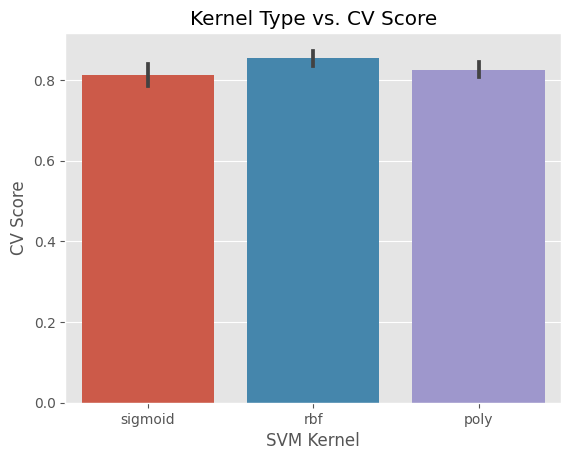

In [15]:
sns.barplot(data=grid_cv_results_svm, x='param_svc__kernel', y='mean_test_score')
plt.ylabel('CV Score')
plt.xlabel('SVM Kernel')
plt.title('Kernel Type vs. CV Score')
plt.show()

In [18]:
grid_cv_svm.best_params_

{'simpleimputer__strategy': 'mean',
 'standardscaler': None,
 'svc__C': 0.2,
 'svc__class_weight': None,
 'svc__gamma': 'scale',
 'svc__kernel': 'sigmoid'}

In [20]:
final_svm = grid_cv_svm.best_estimator_
final_svm.fit(X_train, y_train)
y_hat_svm = final_svm.predict(X_test)
recall_svm = recall_score(y_test, y_hat_svm)

print(f'SVM Train CV Score (recall): {grid_cv_svm.best_score_:.3f}')
print(f'SVM Test Recall: {recall_svm:.3f}')

SVM Train CV Score (recall): 1.000
SVM Test Recall: 1.000


In [21]:
final_svm_performance = {'model': 'support_vector_machine', 
                          'params': final_svm.get_params(), 
                          'train_score_cv_recall': grid_cv_svm.best_score_, 
                          'test_score_recall': recall_svm}

field_names = final_svm_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_svm_performance)